# JIND-Multi Notebook Tutorial

This notebook provides a step-by-step guide on how to run the JIND-Multi method using the Pancreas scRNA-seq dataset as an example. Specifically, batch 0 will be used as the source, batch 2 as the target, and batch 1 as an additional intermediate dataset. Since we have labels for the target batch, we will use confusion matrices to evaluate the results.

## 1. Initial Setup

First, let's ensure we have the necessary dependencies and import the `jind_multi` package.

In [1]:
#To use in google colab install this 2 packgages
#!pip install pandas==1.3.5 \
#  scanpy==1.8.0

In [2]:
import sys
import os
import ast

# Get the path to the project root directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the path to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

# Import the jind_multi package
import jind_multi

# 2. Configuring Parameters

In this section, we define the inputs required for running JIND-Multi by specifying various parameters. These inputs include:

- **Path to the `.h5ad` file**: This is the location of the data file containing the single-cell RNA sequencing data.
- **Batch and cell type column names**: We specify the column names for batch information and cell types within the AnnData object.
- **Source and target batch names**: We indicate which batch will be used as the source for annotation transfer and which batch will be the target for annotation.
- **Output path**: This is where the results of the analysis will be saved.
- **Training configurations**: These include the number of features to consider in the model, the minimum number of cells required per cell type for training in each batch, and whether to use a GPU for computation.
- **Intermediate datasets**: The `TRAIN_DATASETS_NAMES` parameter specifies which batches are used as intermediate datasets for training. These datasets, excluding the source and target batches, help in improving the model’s performance by providing additional training data.

We define these parameters in the `Args` class, which will be used to configure and run the JIND-Multi method.


In [3]:
class Args:
    PATH = "../resources/data/pancreas/pancreas.h5ad"  # path to your data
    BATCH_COL = "batch" # Column name for batch information in the AnnData object
    LABELS_COL = "celltype" # Column name for cell types in the AnnData object
    SOURCE_DATASET_NAME = "0" # Name of the source batch
    TARGET_DATASET_NAME = "2" # Name of the target batch
    OUTPUT_PATH = "../results/pancreas" # Directory to save results
    PRETRAINED_MODEL_PATH = "" # Path to pre-trained models, if available (here we are not introducing any)
    INTER_DATASETS_NAMES = "['1']" # List of intermediate datasets for training
    NUM_FEATURES = 5000 # Number of features (genes) to consider for modeling
    MIN_CELL_TYPE_POPULATION = 100 # Minimum number of cells required per cell type for training
    USE_GPU = True # Whether to use GPU for computation

args = Args()
print(args.PATH)

../resources/data/pancreas/pancreas.h5ad


# 3. Setting Up the Training Configuration
We adjust the training configuration according to the specified parameters.

In [4]:
# Set up training configuration (you can modify more things here)
config = jind_multi.get_config()
config['data']['num_features'] = args.NUM_FEATURES
config['data']['min_cell_type_population'] = args.MIN_CELL_TYPE_POPULATION
config['train_classifier']['cuda'] = args.USE_GPU
config['GAN']['cuda'] = args.USE_GPU
config['ftune']['cuda'] = args.USE_GPU
print(f'USE_GPU: {args.USE_GPU}')
print(config)

USE_GPU: True
{'ftune_intermediate': True, 'retrain_intermediate': True, 'align_target_to_source': False, 'plot_tsne': False, 'cmat_print_counts': True, 'save_results_to_sheets': True, 'train_classifier': {'val_frac': 0.2, 'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15}, 'GAN': {'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15, 'epochs_da': 15, 'gdecay': 0.01, 'ddecay': 0.001, 'maxcount': 7, 'val_frac': 0.1, 'version': 'domain_adapt'}, 'ftune': {'version': 'ftune', 'val_frac': 0.1, 'seed': 0, 'batch_size': 32, 'cuda': True, 'epochs': 15, 'epochs_intermediate': 5, 'retrain_encoder': True, 'use_all_labels': True, 'mini_batch_len': 'MAX', 'mini_batch_splits': 1, 'ftune_retrain_model_epochs': 5, 'metric': 'accuracy'}, 'data': {'count_normalize': True, 'log_transformation': True, 'num_features': 5000, 'min_cell_type_population': 100, 'max_cells_for_dataset': 50000, 'test_data_path': '../resources/data/test/', 'human_brain_neurips_data_path': '../resources/data/human_brain/

# 4. Loading and Processing Data
We load and process the data using the `load_and_process_data` function from the `jind_multi` package. Then, we divide the data into training and test sets.

In [5]:
# Load and process the data
data = jind_multi.load_and_process_data(args, config)

# Split into training and test datasets
train_data = data[data['batch'] != args.TARGET_DATASET_NAME]
test_data = data[data['batch'] == args.TARGET_DATASET_NAME]

/opt/anaconda3/envs/jind/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/anaconda3/envs/jind/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


[Utils] Variance based dimension reduction ...
[Utils][filter_cells] Batch '2': endothelial only has 16 cells (min cell type population = 100)
[Utils][filter_cells] Batch '2': epsilon only has 7 cells (min cell type population = 100)
[Utils][filter_cells] Batch '1': endothelial only has 21 cells (min cell type population = 100)
[Utils][filter_cells] Batch '1': epsilon only has 3 cells (min cell type population = 100)
[Utils][filter_cells] Batch '0': epsilon only has 18 cells (min cell type population = 100)
[Utils][filter_cells] Cell type population count in data:  ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [1362 4024 3243  908 1708  553]
[Utils] 2:  (2038, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [185 886 270 114 386 197]
[Utils] 1:  (2018, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [219 812 448 193 245 101]
[Utils] 0:  (7742, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [ 958 2326 2525  601 1077  255]


# 5. Creating the JIND-Multi Object
We create an instance of the JindWrapper class, which encapsulates the functionality of JIND-Multi, including training and evaluating the model.

In [7]:
inter_datasets_names = ast.literal_eval(args.INTER_DATASETS_NAMES)

jind = jind_multi.JindWrapper(
    train_data=train_data,
    train_dataset_names=inter_datasets_names,
    source_dataset_name=args.SOURCE_DATASET_NAME,
    output_path=args.OUTPUT_PATH,
    config=config
)

# 6. Training the Model
Now we train the model and we infer the labels on the test dataset (target batch).

Epoch 0 Train: 1.7484:   0%|          | 0/49 [00:00<?, ?it/s]


[JindWrapper] Starting JIND training. Run Id = pancreas

[JindWrapper] No trained model was provided

[JindWrapper] Training encoder classifier using 0 dataset (7742, 2450)

[JindWrapper] Training classifier ...


Epoch 1 Train: 0.0373:  14%|█▍        | 7/49 [00:00<00:00, 67.74it/s]

Validation Accuracy 0.9632


Epoch 2 Train: 0.0092:  14%|█▍        | 7/49 [00:00<00:00, 65.08it/s]

Validation Accuracy 0.9813


Epoch 3 Train: 0.0037:  16%|█▋        | 8/49 [00:00<00:00, 70.35it/s]

Validation Accuracy 0.9852


Epoch 4 Train: 0.0006:  14%|█▍        | 7/49 [00:00<00:00, 68.40it/s]

Validation Accuracy 0.9852


Epoch 5 Train: 0.0003:  14%|█▍        | 7/49 [00:00<00:00, 68.11it/s]

Validation Accuracy 0.9871


Epoch 6 Train: 0.0002:  14%|█▍        | 7/49 [00:00<00:00, 66.25it/s]

Validation Accuracy 0.9877


Epoch 7 Train: 0.0004:  16%|█▋        | 8/49 [00:00<00:00, 70.68it/s]

Validation Accuracy 0.9871


Epoch 8 Train: 0.0002:  16%|█▋        | 8/49 [00:00<00:00, 71.18it/s]

Validation Accuracy 0.9864


Epoch 9 Train: 0.0002:  18%|█▊        | 9/49 [00:00<00:00, 83.14it/s]

Validation Accuracy 0.9871


Epoch 10 Train: 0.0002:  14%|█▍        | 7/49 [00:00<00:00, 66.29it/s]

Validation Accuracy 0.9864


Epoch 11 Train: 0.0002:  16%|█▋        | 8/49 [00:00<00:00, 77.75it/s]

Validation Accuracy 0.9845


Epoch 12 Train: 0.0001:  18%|█▊        | 9/49 [00:00<00:00, 84.97it/s]

Validation Accuracy 0.9884


Epoch 13 Train: 0.0001:  16%|█▋        | 8/49 [00:00<00:00, 70.42it/s]

Validation Accuracy 0.9877


Epoch 14 Train: 0.0001:  18%|█▊        | 9/49 [00:00<00:00, 83.00it/s]

Validation Accuracy 0.9877


Epoch 14 Train: 0.0001: 100%|██████████| 49/49 [00:00<00:00, 83.86it/s]


Validation Accuracy 0.9871
[JindLib] Using custom model for dataset 0
[JindLib][Evaluate] Accuracy: T 7742 #Rej 97 (1.3%) corrct 7638 (raw 99.768% eff 99.908%) incorrct 7 mAP 99.973%  {'0'}

[JindWrapper] Training JIND for intermediate dataset 1 Train data shape =  (7742, 2450) Intermediate data shape =  (2018, 2450)
[JindLib] No custom model exists for dataset 1. Using 0 dataset model
[JindLib][Evaluate] Accuracy: T 2018 #Rej 1435 (71.1%) corrct 571 (raw 87.413% eff 97.942%) incorrct 12 mAP 92.447%  {'1'}


Epoch 0: 0.5697: 1::   0%|          | 0/15 [00:00<?, ?it/s]

[JindWrapper] Performing Domain Adaptation for {'1'} dataset


Epoch 0: 0.3701: 1:: 100%|██████████| 15/15 [00:00<00:00, 15.71it/s]


Validation Accuracy = 0.9653. Loss = 0.37
[JindLib] Using custom model for dataset 1


Epoch 1: 0.2949: 1::  13%|█▎        | 2/15 [00:00<00:00, 14.22it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 1471 (72.9%) corrct 537 (raw 95.342% eff 98.172%) incorrct 10 mAP 96.998%  {'1'}


Epoch 1: 0.1487: 1:: 100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Validation Accuracy = 0.9653. Loss = 0.14
[JindLib] Using custom model for dataset 1


Epoch 2: 0.0712: 1::  13%|█▎        | 2/15 [00:00<00:00, 13.92it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 1101 (54.6%) corrct 903 (raw 96.383% eff 98.473%) incorrct 14 mAP 97.492%  {'1'}


Epoch 2: 0.1199: 1:: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


Validation Accuracy = 0.9703. Loss = 0.11
[JindLib] Using custom model for dataset 1


Epoch 3: 0.1285: 1::  13%|█▎        | 2/15 [00:00<00:01, 12.46it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 714 (35.4%) corrct 1290 (raw 96.829% eff 98.926%) incorrct 14 mAP 97.880%  {'1'}


Epoch 3: 0.0932: 1:: 100%|██████████| 15/15 [00:01<00:00, 14.69it/s]


Validation Accuracy = 0.9703. Loss = 0.09
[JindLib] Using custom model for dataset 1


Epoch 4: 0.0762: 1::  13%|█▎        | 2/15 [00:00<00:00, 14.16it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 670 (33.2%) corrct 1335 (raw 97.027% eff 99.036%) incorrct 13 mAP 98.169%  {'1'}


Epoch 4: 0.0703: 1:: 100%|██████████| 15/15 [00:01<00:00, 14.19it/s]


Validation Accuracy = 0.9703. Loss = 0.07
[JindLib] Using custom model for dataset 1


Epoch 5: 0.0274: 1::  13%|█▎        | 2/15 [00:00<00:00, 15.04it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 624 (30.9%) corrct 1381 (raw 97.374% eff 99.067%) incorrct 13 mAP 98.519%  {'1'}


Epoch 5: 0.0502: 1:: 100%|██████████| 15/15 [00:00<00:00, 16.63it/s]


Validation Accuracy = 0.9703. Loss = 0.05
[JindLib] Using custom model for dataset 1


Epoch 6: 0.061: 1::  13%|█▎        | 2/15 [00:00<00:00, 15.31it/s] 

[JindLib][Evaluate] Accuracy: T 2018 #Rej 565 (28.0%) corrct 1441 (raw 97.671% eff 99.174%) incorrct 12 mAP 98.844%  {'1'}


Epoch 6: 0.034: 1:: 100%|██████████| 15/15 [00:00<00:00, 16.81it/s] 


Validation Accuracy = 0.9752. Loss = 0.03
[JindLib] Using custom model for dataset 1


Epoch 7: 0.0199: 1::  13%|█▎        | 2/15 [00:00<00:00, 14.79it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 466 (23.1%) corrct 1544 (raw 97.869% eff 99.485%) incorrct 8 mAP 99.064%  {'1'}


Epoch 7: 0.0218: 1:: 100%|██████████| 15/15 [00:00<00:00, 15.08it/s]


Validation Accuracy = 0.9802. Loss = 0.02
[JindLib] Using custom model for dataset 1


Epoch 8: 0.0212: 1::  13%|█▎        | 2/15 [00:00<00:00, 15.04it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 384 (19.0%) corrct 1627 (raw 98.216% eff 99.572%) incorrct 7 mAP 99.169%  {'1'}


Epoch 8: 0.0146: 1:: 100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


Validation Accuracy = 0.9752. Loss = 0.01
[JindLib] Using custom model for dataset 1


Epoch 9: 0.0074: 1::  13%|█▎        | 2/15 [00:00<00:00, 13.96it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 335 (16.6%) corrct 1675 (raw 98.513% eff 99.525%) incorrct 8 mAP 99.251%  {'1'}


Epoch 9: 0.0097: 1:: 100%|██████████| 15/15 [00:01<00:00, 14.98it/s]


Validation Accuracy = 0.9752. Loss = 0.00
[JindLib] Using custom model for dataset 1


Epoch 10: 0.0132: 1::  13%|█▎        | 2/15 [00:00<00:00, 14.93it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 260 (12.9%) corrct 1750 (raw 98.612% eff 99.545%) incorrct 8 mAP 99.305%  {'1'}


Epoch 10: 0.0068: 1:: 100%|██████████| 15/15 [00:00<00:00, 15.31it/s]


Validation Accuracy = 0.9752. Loss = 0.00
[JindLib] Using custom model for dataset 1


Epoch 11: 0.0074: 1::  13%|█▎        | 2/15 [00:00<00:00, 15.50it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 209 (10.4%) corrct 1800 (raw 98.662% eff 99.502%) incorrct 9 mAP 99.305%  {'1'}


Epoch 11: 0.0041: 1:: 100%|██████████| 15/15 [00:00<00:00, 17.22it/s]


Validation Accuracy = 0.9752. Loss = 0.00
[JindLib] Using custom model for dataset 1


Epoch 12: 0.0013: 1::  13%|█▎        | 2/15 [00:00<00:01, 12.89it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 173 (8.6%) corrct 1836 (raw 98.761% eff 99.512%) incorrct 9 mAP 99.346%  {'1'}


Epoch 12: 0.0025: 1:: 100%|██████████| 15/15 [00:01<00:00, 14.90it/s]


Validation Accuracy = 0.9752. Loss = 0.00
[JindLib] Using custom model for dataset 1


Epoch 13: 0.0025: 1::  13%|█▎        | 2/15 [00:00<00:00, 16.01it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 167 (8.3%) corrct 1841 (raw 98.761% eff 99.460%) incorrct 10 mAP 99.332%  {'1'}


Epoch 13: 0.0019: 1:: 100%|██████████| 15/15 [00:00<00:00, 17.38it/s]


Validation Accuracy = 0.9752. Loss = 0.00
[JindLib] Using custom model for dataset 1


Epoch 14: 0.0017: 1::  13%|█▎        | 2/15 [00:00<00:00, 13.82it/s]

[JindLib][Evaluate] Accuracy: T 2018 #Rej 153 (7.6%) corrct 1855 (raw 98.712% eff 99.464%) incorrct 10 mAP 99.335%  {'1'}


Epoch 14: 0.0011: 1:: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


Validation Accuracy = 0.9752. Loss = 0.00
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 134 (6.6%) corrct 1874 (raw 98.761% eff 99.469%) incorrct 10 mAP 99.370%  {'1'}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 134 (6.6%) corrct 1874 (raw 98.761% eff 99.469%) incorrct 10 mAP 99.370%  {'1'}


Epoch 0: Loss 0.0001: Dataset 0::  18%|█▊        | 9/49 [00:00<00:00, 84.40it/s]


[JindWrapper] Fine tuning in parallel for {'1', '0'} dataset


Epoch 0: Loss 0.0007: Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 23.53it/s]


Validation accuracy = 0.9815. Loss = 0.0011 {'0': 0.9877, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 79 (3.9%) corrct 1925 (raw 98.712% eff 99.278%) incorrct 14 mAP 99.365%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 1: Loss 0.0 : Dataset 0::   4%|▍         | 2/49 [00:00<00:02, 19.43it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 70 (0.9%) corrct 7665 (raw 99.755% eff 99.909%) incorrct 7 mAP 99.975%  {'0'}


Epoch 1: Loss 0.0002: Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 29.46it/s]


Validation accuracy = 0.9815. Loss = 0.0002 {'0': 0.9877, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 56 (2.8%) corrct 1947 (raw 98.761% eff 99.235%) incorrct 15 mAP 99.395%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 2: Loss 0.0 : Dataset 0::  18%|█▊        | 9/49 [00:00<00:00, 89.86it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 67 (0.9%) corrct 7667 (raw 99.755% eff 99.896%) incorrct 8 mAP 99.967%  {'0'}


Epoch 2: Loss 0.0001: Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 29.52it/s]


Validation accuracy = 0.9808. Loss = 0.0002 {'0': 0.9864, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 49 (2.4%) corrct 1954 (raw 98.761% eff 99.238%) incorrct 15 mAP 99.406%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 3: Loss 0.0 : Dataset 0::  18%|█▊        | 9/49 [00:00<00:00, 89.33it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 66 (0.9%) corrct 7668 (raw 99.742% eff 99.896%) incorrct 8 mAP 99.967%  {'0'}


Epoch 3: Loss 0.0001: Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 30.28it/s]


Validation accuracy = 0.9812. Loss = 0.0001 {'0': 0.9871, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 42 (2.1%) corrct 1961 (raw 98.712% eff 99.241%) incorrct 15 mAP 99.408%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 4: Loss 0.0 : Dataset 0::  20%|██        | 10/49 [00:00<00:00, 91.66it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 65 (0.8%) corrct 7670 (raw 99.742% eff 99.909%) incorrct 7 mAP 99.967%  {'0'}


Epoch 4: Loss 0.0 : Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 26.00it/s]


Validation accuracy = 0.9812. Loss = 0.0  {'0': 0.9871, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 38 (1.9%) corrct 1964 (raw 98.761% eff 99.192%) incorrct 16 mAP 99.406%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 5: Loss 0.0 : Dataset 0::  20%|██        | 10/49 [00:00<00:00, 91.33it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 65 (0.8%) corrct 7668 (raw 99.729% eff 99.883%) incorrct 9 mAP 99.968%  {'0'}


Epoch 6: Loss 0.0 : Dataset 0::  20%|██        | 10/49 [00:00<00:00, 96.42it/s]

Validation accuracy = 0.9818. Loss = 0.0001 {'0': 0.9884, '1': 0.9752}


Epoch 6: Loss 0.0001: Dataset 1::  20%|██        | 3/15 [00:00<00:00, 28.88it/s]

Epoch     7: reducing learning rate of group 0 to 5.0000e-05.


Epoch 7: Loss 0.0 : Dataset 0::  20%|██        | 10/49 [00:00<00:00, 93.61it/s]

Validation accuracy = 0.9808. Loss = 0.0001 {'0': 0.9864, '1': 0.9752}


Epoch 7: Loss 0.0 : Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 25.38it/s] 


Validation accuracy = 0.9815. Loss = 0.0  {'0': 0.9877, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 30 (1.5%) corrct 1971 (raw 98.662% eff 99.145%) incorrct 17 mAP 99.388%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 8: Loss 0.0 : Dataset 0::  18%|█▊        | 9/49 [00:00<00:00, 83.68it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 57 (0.7%) corrct 7677 (raw 99.729% eff 99.896%) incorrct 8 mAP 99.967%  {'0'}


Epoch 9: Loss 0.0 : Dataset 0::  20%|██        | 10/49 [00:00<00:00, 91.05it/s]

Validation accuracy = 0.9821. Loss = 0.0  {'0': 0.989, '1': 0.9752}


Epoch 9: Loss 0.0 : Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 28.74it/s]


Validation accuracy = 0.9821. Loss = 0.0  {'0': 0.989, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 29 (1.4%) corrct 1972 (raw 98.712% eff 99.145%) incorrct 17 mAP 99.397%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 10: Loss 0.0 : Dataset 0::  18%|█▊        | 9/49 [00:00<00:00, 85.78it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 50 (0.6%) corrct 7683 (raw 99.768% eff 99.883%) incorrct 9 mAP 99.968%  {'0'}


Epoch 10: Loss 0.0 : Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 28.66it/s]


Validation accuracy = 0.9818. Loss = 0.0  {'0': 0.9884, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 28 (1.4%) corrct 1973 (raw 98.712% eff 99.146%) incorrct 17 mAP 99.406%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 11: Loss 0.0 : Dataset 0::   4%|▍         | 2/49 [00:00<00:02, 19.30it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 52 (0.7%) corrct 7681 (raw 99.768% eff 99.883%) incorrct 9 mAP 99.968%  {'0'}


Epoch 11: Loss 0.0 : Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 28.08it/s]


Validation accuracy = 0.9821. Loss = 0.0  {'0': 0.989, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 27 (1.3%) corrct 1974 (raw 98.712% eff 99.146%) incorrct 17 mAP 99.386%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 12: Loss 0.0 : Dataset 0::  16%|█▋        | 8/49 [00:00<00:00, 76.61it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 50 (0.6%) corrct 7683 (raw 99.780% eff 99.883%) incorrct 9 mAP 99.968%  {'0'}


Epoch 12: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 26.75it/s]

Epoch    13: reducing learning rate of group 0 to 2.5000e-05.


Epoch 13: Loss 0.0 : Dataset 0::  18%|█▊        | 9/49 [00:00<00:00, 81.12it/s]

Validation accuracy = 0.9815. Loss = 0.0  {'0': 0.9877, '1': 0.9752}


Epoch 14: Loss 0.0 : Dataset 0::  16%|█▋        | 8/49 [00:00<00:00, 79.70it/s]

Epoch    14: reducing learning rate of group 0 to 5.0000e-05.
Validation accuracy = 0.9815. Loss = 0.0001 {'0': 0.9877, '1': 0.9752}


Epoch 14: Loss 0.0 : Dataset 1:: 100%|██████████| 15/15 [00:00<00:00, 23.27it/s]


Validation accuracy = 0.9815. Loss = 0.0  {'0': 0.9877, '1': 0.9752}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 27 (1.3%) corrct 1974 (raw 98.712% eff 99.146%) incorrct 17 mAP 99.385%  {'1'}
[JindLib] Using custom model for dataset 0
[JindLib][Evaluate] Accuracy: T 7742 #Rej 54 (0.7%) corrct 7679 (raw 99.742% eff 99.883%) incorrct 9 mAP 99.968%  {'0'}
[JindLib] Using custom model for dataset 0
[JindLib][Evaluate] Accuracy: T 7742 #Rej 54 (0.7%) corrct 7679 (raw 99.742% eff 99.883%) incorrct 9 mAP 99.968%  {'0'}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 27 (1.3%) corrct 1974 (raw 98.712% eff 99.146%) incorrct 17 mAP 99.385%  {'1'}


Epoch 0: Loss 0.0 : Dataset 1::  13%|█▎        | 2/15 [00:00<00:00, 17.96it/s]


[JindWrapper] Re-training all JIND labeled dataset models in parallel -  {'1', '0'}


Epoch 0: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 79.15it/s]


Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 24 (1.2%) corrct 1977 (raw 98.712% eff 99.147%) incorrct 17 mAP 99.378%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 1: Loss 0.0 : Dataset 1::   7%|▋         | 1/15 [00:00<00:01,  7.33it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 44 (0.6%) corrct 7689 (raw 99.755% eff 99.883%) incorrct 9 mAP 99.969%  {'0'}


Epoch 1: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 76.37it/s]


Validation accuracy = 0.9818. Loss = 0.0  {'1': 0.9752, '0': 0.9884}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 22 (1.1%) corrct 1979 (raw 98.761% eff 99.148%) incorrct 17 mAP 99.371%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 2: Loss 0.0 : Dataset 1::  13%|█▎        | 2/15 [00:00<00:00, 19.67it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 39 (0.5%) corrct 7693 (raw 99.768% eff 99.870%) incorrct 10 mAP 99.971%  {'0'}


Epoch 3: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 23.49it/s]

Validation accuracy = 0.9812. Loss = 0.0002 {'1': 0.9752, '0': 0.9871}


Epoch 4: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 23.31it/s]

Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}


Epoch 4: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 67.57it/s]


Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 19 (0.9%) corrct 1982 (raw 98.712% eff 99.150%) incorrct 17 mAP 99.372%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 5: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 21.29it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 39 (0.5%) corrct 7693 (raw 99.755% eff 99.870%) incorrct 10 mAP 99.968%  {'0'}


Epoch 6: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 23.76it/s]

Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}


Epoch 6: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 76.04it/s]


Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 19 (0.9%) corrct 1981 (raw 98.712% eff 99.100%) incorrct 18 mAP 99.389%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 7: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 21.52it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 41 (0.5%) corrct 7691 (raw 99.755% eff 99.870%) incorrct 10 mAP 99.970%  {'0'}


Epoch 8: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 23.57it/s]

Validation accuracy = 0.9812. Loss = 0.0  {'1': 0.9752, '0': 0.9871}


Epoch 9: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 23.76it/s]

Validation accuracy = 0.9808. Loss = 0.0  {'1': 0.9752, '0': 0.9864}


Epoch 9: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 67.74it/s]


Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 18 (0.9%) corrct 1983 (raw 98.712% eff 99.150%) incorrct 17 mAP 99.374%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 10: Loss 0.0 : Dataset 1::  13%|█▎        | 2/15 [00:00<00:00, 19.77it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 38 (0.5%) corrct 7694 (raw 99.755% eff 99.870%) incorrct 10 mAP 99.969%  {'0'}


Epoch 10: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 76.48it/s]


Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 18 (0.9%) corrct 1982 (raw 98.712% eff 99.100%) incorrct 18 mAP 99.379%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 11: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 21.43it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 36 (0.5%) corrct 7695 (raw 99.755% eff 99.857%) incorrct 11 mAP 99.966%  {'0'}


Epoch 11: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 76.43it/s]


Validation accuracy = 0.9815. Loss = 0.0  {'1': 0.9752, '0': 0.9877}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 18 (0.9%) corrct 1982 (raw 98.712% eff 99.100%) incorrct 18 mAP 99.378%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 12: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 21.47it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 36 (0.5%) corrct 7696 (raw 99.755% eff 99.870%) incorrct 10 mAP 99.964%  {'0'}


Epoch 12: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:00<00:00, 67.09it/s]


Validation accuracy = 0.9812. Loss = 0.0  {'1': 0.9752, '0': 0.9871}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 17 (0.8%) corrct 1983 (raw 98.761% eff 99.100%) incorrct 18 mAP 99.384%  {'1'}
[JindLib] Using custom model for dataset 0


Epoch 13: Loss 0.0 : Dataset 1::  13%|█▎        | 2/15 [00:00<00:01, 12.91it/s]

[JindLib][Evaluate] Accuracy: T 7742 #Rej 37 (0.5%) corrct 7695 (raw 99.742% eff 99.870%) incorrct 10 mAP 99.965%  {'0'}


Epoch 14: Loss 0.0 : Dataset 1::  20%|██        | 3/15 [00:00<00:00, 20.60it/s]

Validation accuracy = 0.9812. Loss = 0.0  {'1': 0.9752, '0': 0.9871}


Epoch 14: Loss 0.0 : Dataset 0:: 100%|██████████| 49/49 [00:01<00:00, 40.11it/s]


Epoch    15: reducing learning rate of group 0 to 5.0000e-05.
Validation accuracy = 0.9812. Loss = 0.0  {'1': 0.9752, '0': 0.9871}
[JindLib] Using custom model for dataset 0
[JindLib][Evaluate] Accuracy: T 7742 #Rej 37 (0.5%) corrct 7695 (raw 99.742% eff 99.870%) incorrct 10 mAP 99.965%  {'0'}
[JindLib] Using custom model for dataset 1
[JindLib][Evaluate] Accuracy: T 2018 #Rej 17 (0.8%) corrct 1983 (raw 98.761% eff 99.100%) incorrct 18 mAP 99.384%  {'1'}

[JindWrapper] Save Trained Model and val_stats object 

[JindWrapper] Training JIND for target dataset {'2'} Train data shape =  (9760, 2450) Target data shape =  (2038, 2450)
[JindLib] No custom model exists for dataset 2. Using 0 dataset model
[JindLib][Evaluate] Accuracy: T 2038 #Rej 252 (12.4%) corrct 1692 (raw 93.081% eff 94.737%) incorrct 94 mAP 93.204%  {'2'}
[JindWrapper] Removing batch effect by mapping {'2'} onto {'1', '0'}
[JindLib] Using custom model for dataset 1
[JindLib] Using custom model for dataset 0
[JindLib] Using 

  0%|          | 0/40 [00:00<?, ?it/s]

[JindLib] Updated Rejected cells from 1.000 to 0.122


Epoch 0 G Loss: 0.774 D Loss: 0.628: 100%|██████████| 40/40 [00:06<00:00,  6.34it/s]


[JindLib] Using custom model for dataset 2


Epoch 1 G Loss: 0.764 D Loss: 0.587:   2%|▎         | 1/40 [00:00<00:06,  6.13it/s]

Updated Rejected cells from 0.122 to 0.115


Epoch 7 G Loss: 0.804 D Loss: 0.668: 100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Loss not improving, stopping alignment
[JindLib] Using custom model for dataset 2
[JindLib][Evaluate] Accuracy: T 2038 #Rej 234 (11.5%) corrct 1726 (raw 90.432% eff 95.676%) incorrct 78 mAP 97.968%  {'2'}
[JindWrapper] Fine tuning JIND for {'2'} dataset
[JindLib] Using custom model for dataset 2


Epoch 0: Loss 0.0001: Dataset 2::   4%|▍         | 2/49 [00:00<00:02, 17.92it/s]

[JindLib] Using 1708 high confidence cells out of 2038 for fine tuning


Epoch 0: Loss 0.0006: Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 35.64it/s]


Validation accuracy = 1.0000. Loss = 0.0006 {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 1: Loss 0.0001: Dataset 2::   6%|▌         | 3/49 [00:00<00:01, 28.12it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 11 (0.6%) corrct 1697 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 1: Loss 0.0001: Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 39.76it/s]


Validation accuracy = 1.0000. Loss = 0.0003 {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 2: Loss 0.0 : Dataset 2::   6%|▌         | 3/49 [00:00<00:01, 27.14it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 2: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 38.31it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 3: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 36.74it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 99.941% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 3: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 42.15it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 4: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 33.64it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 99.941% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 4: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 39.87it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 5: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 35.93it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 99.941% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 5: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 38.77it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 6: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 34.79it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 99.941% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 6: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 43.34it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 7: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 35.56it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 99.941% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 8: Loss 0.0 : Dataset 2::  10%|█         | 5/49 [00:00<00:01, 41.58it/s]

Validation accuracy = 1.0000. Loss = 0.0001 {'2': 1.0}


Epoch 8: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 43.10it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 9: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 34.62it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 99.941% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 9: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 40.37it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 10: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 35.95it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 1 (0.1%) corrct 1707 (raw 99.941% eff 100.000%) incorrct 0 mAP 100.000%  {'2'}


Epoch 11: Loss 0.0 : Dataset 2::  10%|█         | 5/49 [00:00<00:01, 41.93it/s]

Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}


Epoch 12: Loss 0.0 : Dataset 2::  10%|█         | 5/49 [00:00<00:00, 45.14it/s]

Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}


Epoch 12: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 45.43it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 13: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 37.98it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 0 (0.0%) corrct 1707 (raw 99.941% eff 99.941%) incorrct 1 mAP 100.000%  {'2'}


Epoch 13: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 43.04it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2


Epoch 14: Loss 0.0 : Dataset 2::   8%|▊         | 4/49 [00:00<00:01, 36.77it/s]

[JindLib][Evaluate] Accuracy: T 1708 #Rej 0 (0.0%) corrct 1707 (raw 99.941% eff 99.941%) incorrct 1 mAP 100.000%  {'2'}


Epoch 14: Loss 0.0 : Dataset 2:: 100%|██████████| 49/49 [00:01<00:00, 43.82it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'2': 1.0}
[JindLib] Using custom model for dataset 2
[JindLib][Evaluate] Accuracy: T 1708 #Rej 0 (0.0%) corrct 1707 (raw 99.941% eff 99.941%) incorrct 1 mAP 100.000%  {'2'}
[JindLib] Using custom model for dataset 2
[JindLib][Evaluate] Accuracy: T 2038 #Rej 94 (4.6%) corrct 1859 (raw 94.063% eff 95.628%) incorrct 85 mAP 97.037%  {'2'}
[JindWrapper] Getting the test labels predictions
[JindLib] Using custom model for dataset 2
predicted_label
                   raw_predictions predictions        acinar         alpha  \
cellname                                                                     
AZ_A10-2                     delta       delta  4.529619e-11  3.566719e-09   
AZ_A11-2                     alpha       alpha  7.466798e-12  9.999990e-01   
AZ_A12-2                     delta       delta  4.354103e-12  1.114999e-09   
AZ_A2-2                      gamma       gamma  3.909096e-10  2.731892e-08   
AZ_A5-2                     ductal      duc

('94.063', '95.628', '97.037', '4.6')

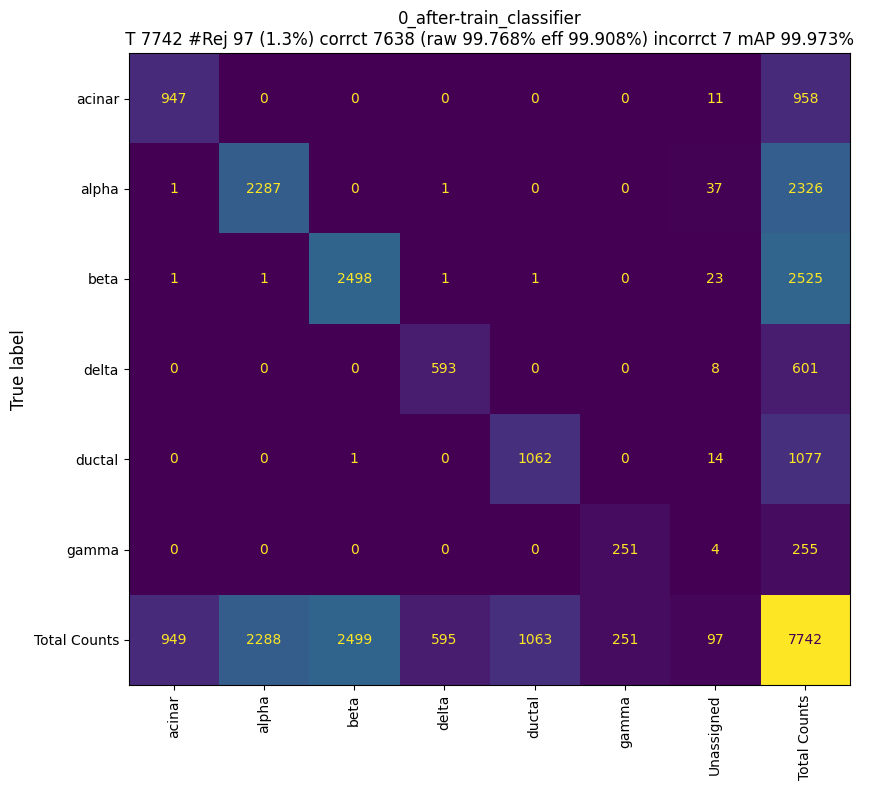

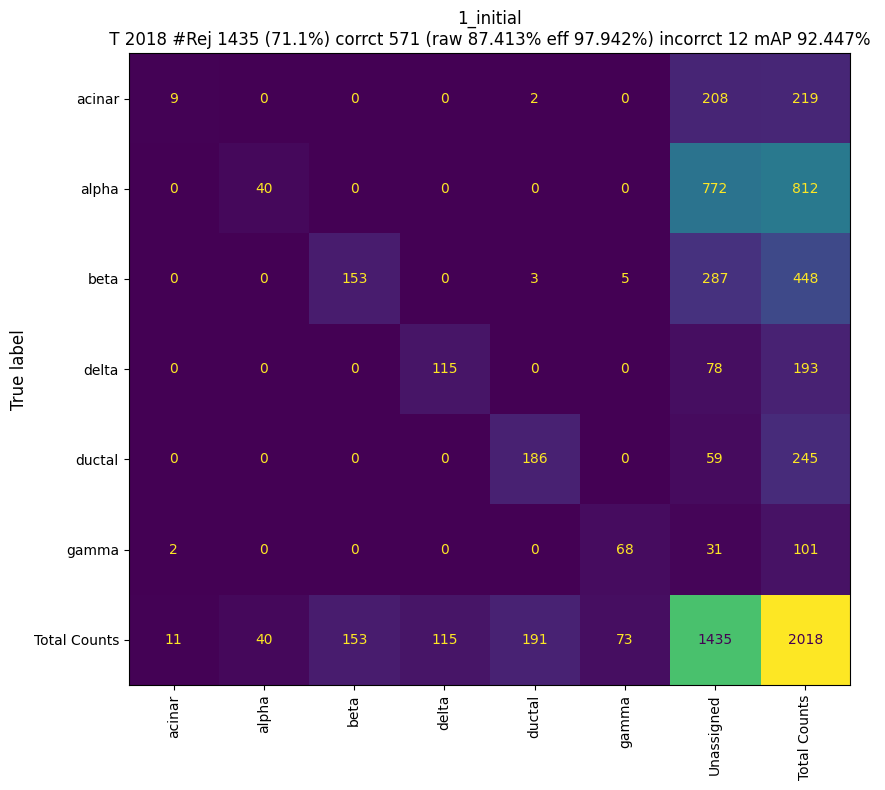

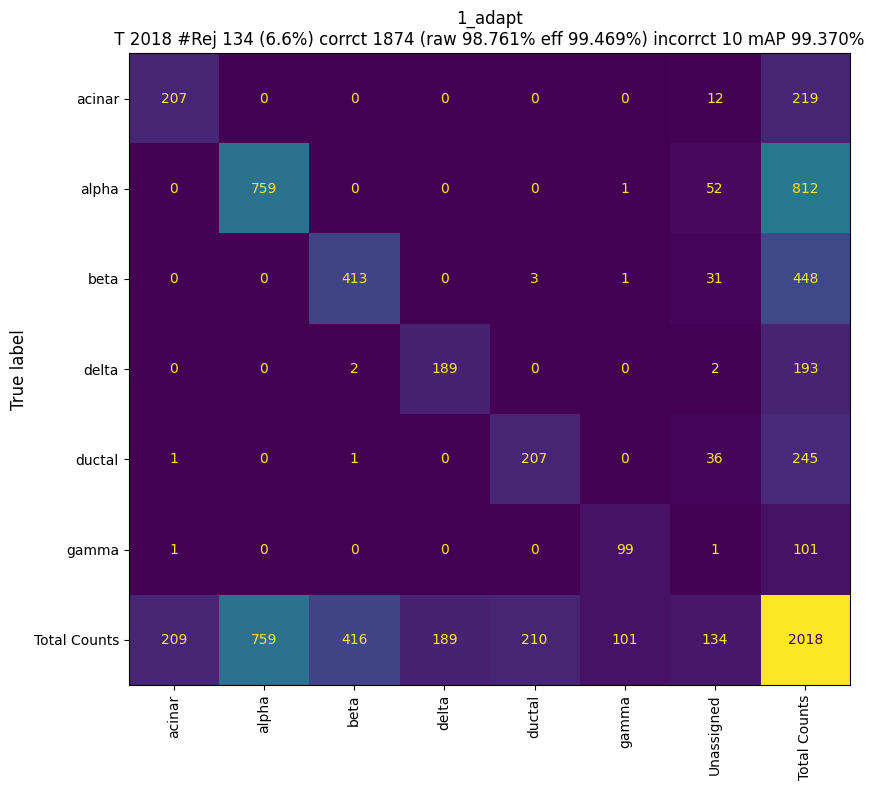

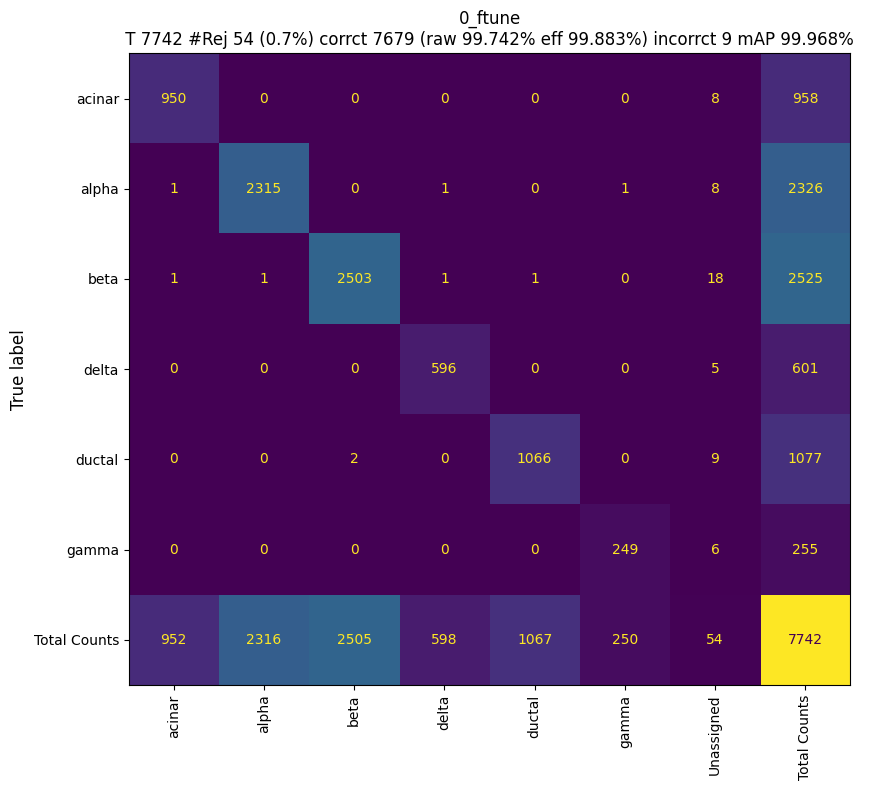

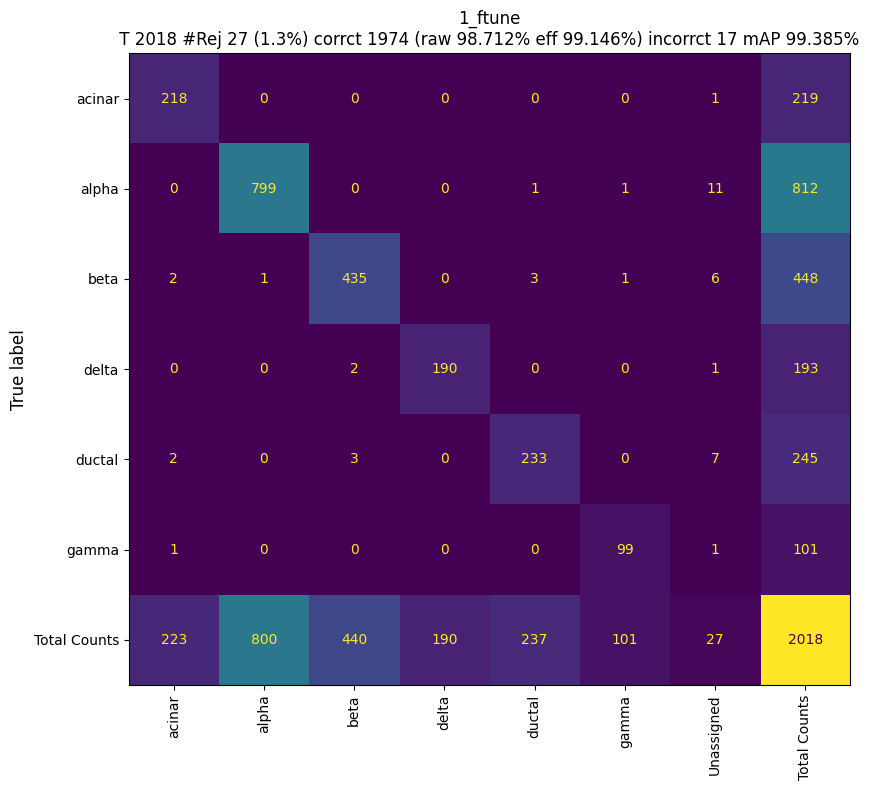

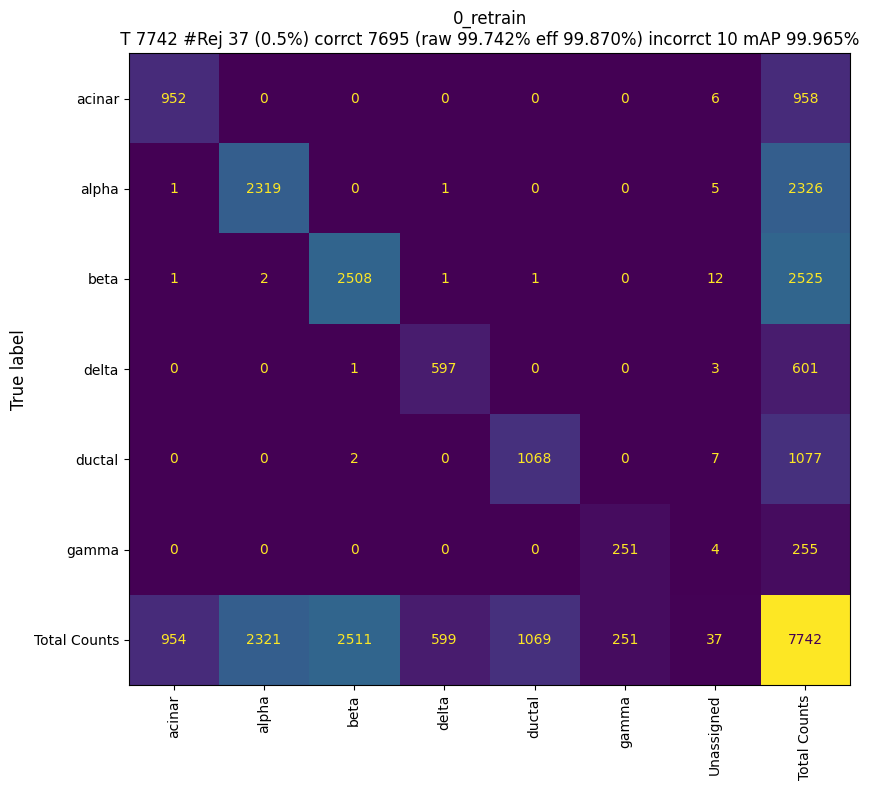

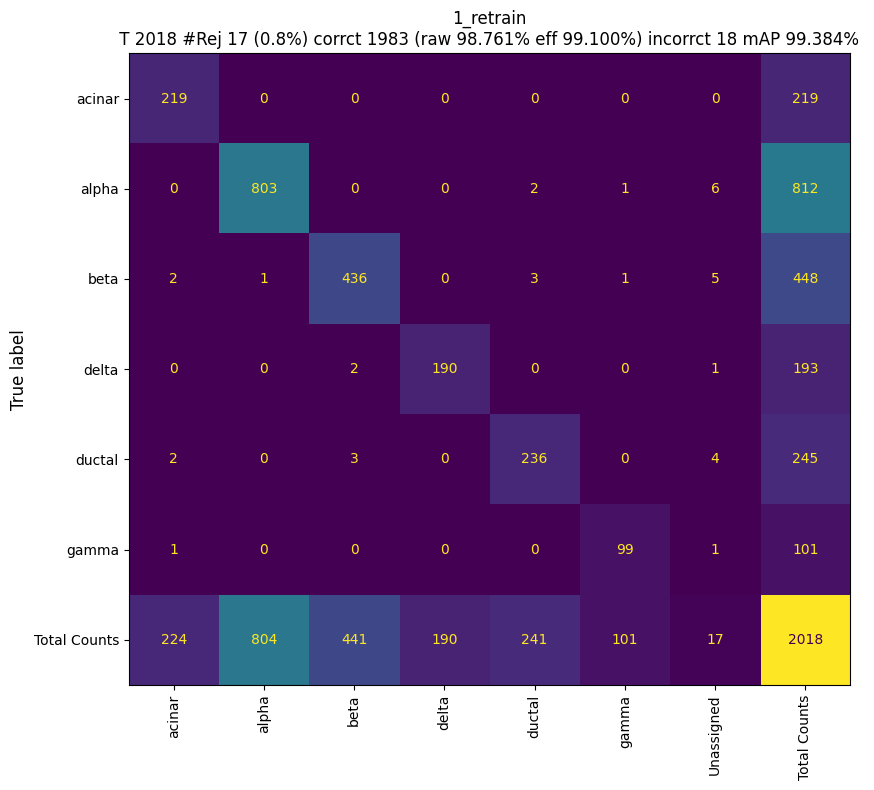

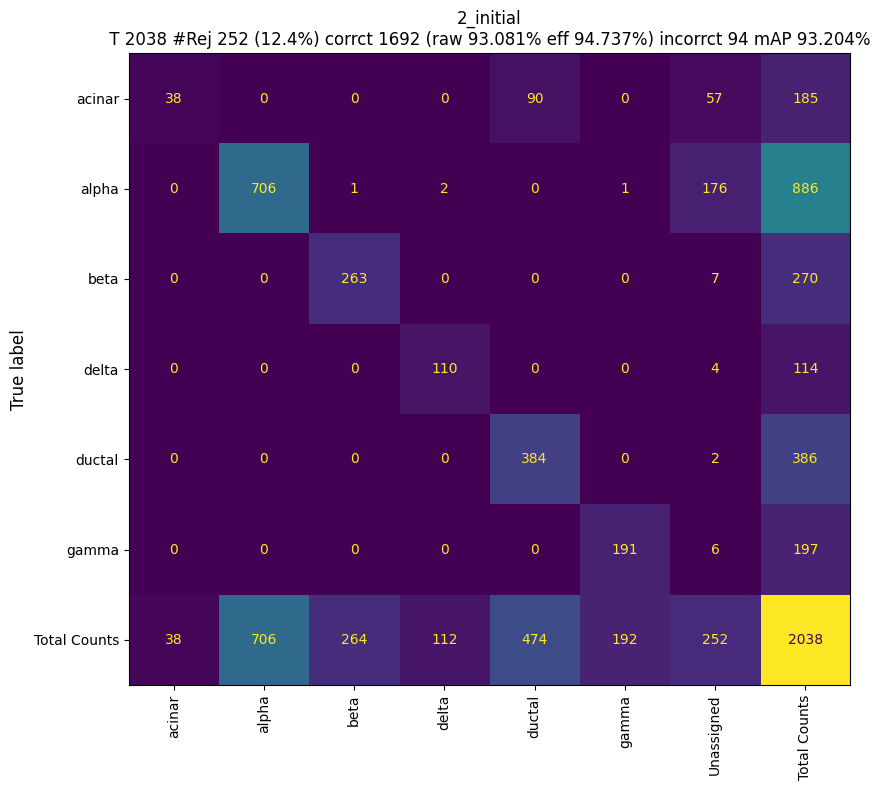

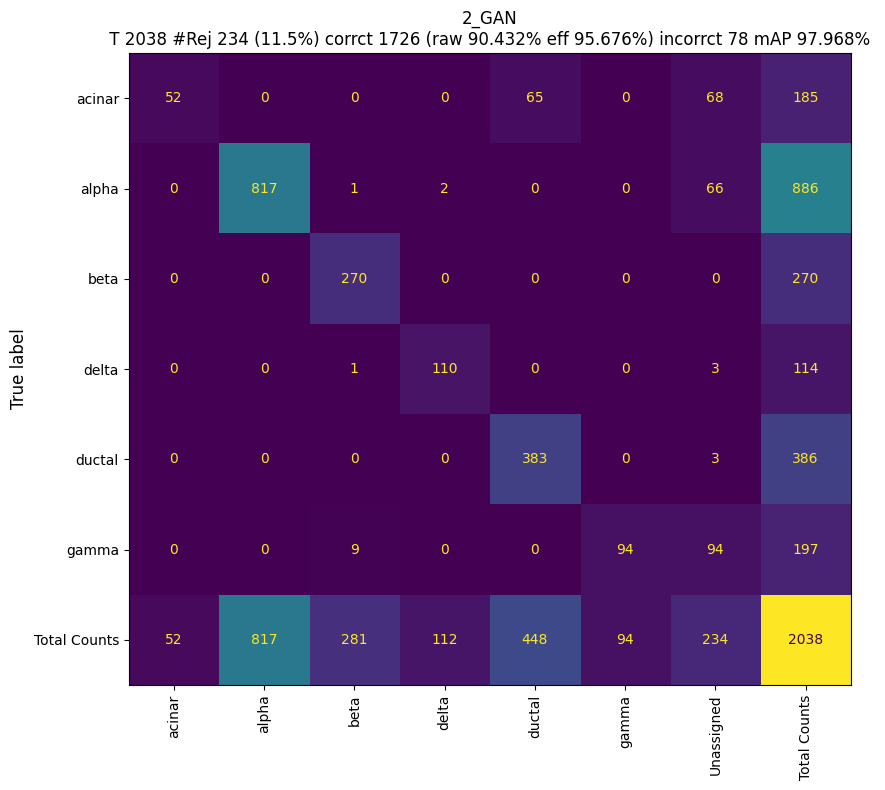

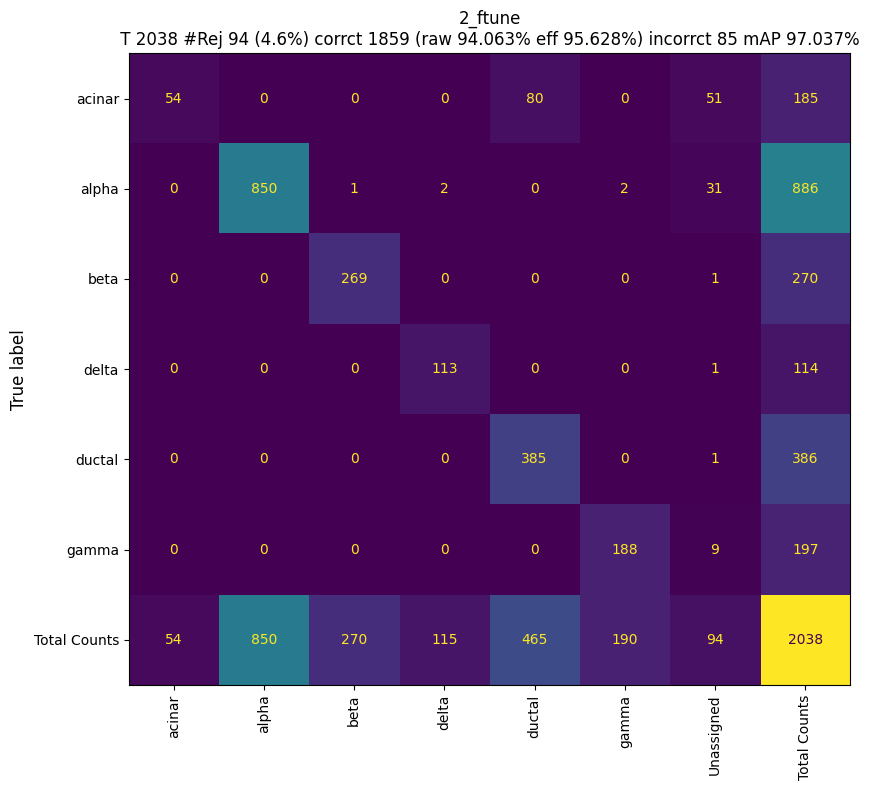

In [8]:
# Train the JIND-Multi model
jind.train(target_data=test_data)

## 7. Applying the Trained Model to a New Target Batch

Once the model has been trained, you may want to apply it to a new target batch. This process involves loading the pre-trained model from the saved directory and using it to make predictions on new data.

### Steps:

1. **Specify the Path to Pre-Trained Models**: Ensure that the path to the directory containing the trained models is correctly set. This directory should include the model files (`.pt` format) and the associated configuration files.

2. **Load the Pre-Trained Model**: Use the `JindWrapper` class to load the pre-trained model from the specified directory.

3. **Apply the Model to the New Target Batch**: Run the model on the new target batch to get predictions.

Here’s how you can do this in code for batch 3:

In [9]:
# Define new parameters for applying the model to a new target batch
class Args:
    PATH = "../resources/data/pancreas/pancreas.h5ad"  # path to your data
    BATCH_COL = "batch" # Column name for batch information in the AnnData object
    LABELS_COL = "celltype" # Column name for cell types in the AnnData object
    SOURCE_DATASET_NAME = "0" # Name of the source batch
    TARGET_DATASET_NAME = "3" # Name of the target batch
    OUTPUT_PATH = "../results/pancreas_target3" # Directory to save results
    PRETRAINED_MODEL_PATH = "../results/pancreas/trained_models" # Path to pre-trained models, if available (here we are not introducing any)
    INTER_DATASETS_NAMES = "['1']" # List of intermediate datasets for training
    NUM_FEATURES = 5000 # Number of features (genes) to consider for modeling
    MIN_CELL_TYPE_POPULATION = 5 # Minimum number of cells required per cell type for training
    USE_GPU = True # Whether to use GPU for computation

args = Args()
print(args.PATH)

../resources/data/pancreas/pancreas.h5ad


In [10]:
# Set up training configuration
config = jind_multi.get_config()
config['data']['num_features'] = args.NUM_FEATURES
config['data']['min_cell_type_population'] = args.MIN_CELL_TYPE_POPULATION
config['train_classifier']['cuda'] = args.USE_GPU
config['GAN']['cuda'] = args.USE_GPU
config['ftune']['cuda'] = args.USE_GPU
print(f'USE_GPU: {args.USE_GPU}')
print(config)

# Load and process the data
data = jind_multi.load_and_process_data(args, config)

USE_GPU: True
{'ftune_intermediate': True, 'retrain_intermediate': True, 'align_target_to_source': False, 'plot_tsne': False, 'cmat_print_counts': True, 'save_results_to_sheets': True, 'train_classifier': {'val_frac': 0.2, 'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15}, 'GAN': {'seed': 0, 'batch_size': 128, 'cuda': True, 'epochs': 15, 'epochs_da': 15, 'gdecay': 0.01, 'ddecay': 0.001, 'maxcount': 7, 'val_frac': 0.1, 'version': 'domain_adapt'}, 'ftune': {'version': 'ftune', 'val_frac': 0.1, 'seed': 0, 'batch_size': 32, 'cuda': True, 'epochs': 15, 'epochs_intermediate': 5, 'retrain_encoder': True, 'use_all_labels': True, 'mini_batch_len': 'MAX', 'mini_batch_splits': 1, 'ftune_retrain_model_epochs': 5, 'metric': 'accuracy'}, 'data': {'count_normalize': True, 'log_transformation': True, 'num_features': 5000, 'min_cell_type_population': 5, 'max_cells_for_dataset': 50000, 'test_data_path': '../resources/data/test/', 'human_brain_neurips_data_path': '../resources/data/human_brain/Al

/opt/anaconda3/envs/jind/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/anaconda3/envs/jind/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


[Utils] Variance based dimension reduction ...
[Utils][filter_cells] Cell type population count in data:  ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [1183 3328 3084  803 1418  374]
[Utils] 1:  (2018, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [219 812 448 193 245 101]
[Utils] 0:  (7742, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [ 958 2326 2525  601 1077  255]
[Utils] 3:  (430, 2450) ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'gamma'] [  6 190 111   9  96  18]


In [11]:
# Split into training and test datasets
train_data = data[data['batch'] != args.TARGET_DATASET_NAME]
test_data = data[data['batch'] == args.TARGET_DATASET_NAME]

# Create the JIND-Multi object
jind2 = jind_multi.JindWrapper(
                                train_data=train_data,
                                source_dataset_name=args.SOURCE_DATASET_NAME,
                                output_path=args.OUTPUT_PATH,
                                config=config,
                            )

### Loading and Applying the Pre-Trained Model

After setting up your parameters and preparing the data, the next step is to load the pre-trained model and use it for predictions on the new target batch. This process involves several steps:

This step identifies the files containing the pre-trained models stored in the specified directory and loads validation statistics used to evaluate the performance of the pre-trained model.

In [12]:
print('Loading pre-trained models from specified path...')
file_paths = jind_multi.find_saved_models(args.PRETRAINED_MODEL_PATH, train_data)  # Check if pre-trained models are available
print(file_paths)
model = jind_multi.load_trained_models(file_paths, train_data, args.SOURCE_DATASET_NAME)
print(model)
print("Loading validation statistics...")
val_stats = jind_multi.load_val_stats(args.PRETRAINED_MODEL_PATH, 'val_stats_trained_model.json')
print(val_stats)

Loading pre-trained models from specified path...
['../results/pancreas/trained_models/0.pt', '../results/pancreas/trained_models/1.pt']

[load_trained_models] Already trained models found in file_paths.
[load_trained_models] Load the Source Classifier Model
[load_trained_models] Trained Classifier Dataset Name: 0
[load_trained_models] Add loaded model to saved model dictionary
[load_trained_models] Load the rest of intermediate models
[load_trained_models] Trained Intermediate model name: 1
[load_trained_models] Add loaded model to saved model dictionary
{'0': Classifier(
  (fc1): Sequential(
    (0): Linear(in_features=2448, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): GaussianNoise()
  )
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=6, bias=True)
  )
), '1': ClassifierBig(
  (m1): Classifier(
    (fc1): Sequential(
      (0): Linear(in_fea

**Applying the Model to the New Target Batch:**


[JindWrapper] Starting JIND training. Run Id = pancreas_target3

[JindWrapper] An already trained model with its val_stats vas provided

[JindWrapper] Using an already trained classifier

[JindWrapper] Training JIND for target dataset {'3'} Train data shape =  (9760, 2450) Target data shape =  (430, 2450)
[JindLib] No custom model exists for dataset 3. Using 0 dataset model
[JindLib][Evaluate] Accuracy: T 430 #Rej 363 (84.4%) corrct 62 (raw 63.488% eff 92.537%) incorrct 5 mAP 79.700%  {'3'}
[JindWrapper] Removing batch effect by mapping {'3'} onto {'1', '0'}
[JindLib] Using custom model for dataset 1
[JindLib] Using custom model for dataset 0
[JindLib] Using custom model for dataset 3


Epoch 0 G Loss: 0.772 D Loss: 0.500:   2%|▎         | 1/40 [00:00<00:05,  7.30it/s]

[JindLib] Updated Rejected cells from 1.000 to 0.835


  0%|          | 0/40 [00:00<?, ?it/s]

[JindLib] Using custom model for dataset 3
Updated Rejected cells from 0.835 to 0.372


  0%|          | 0/40 [00:00<?, ?it/s]

[JindLib] Using custom model for dataset 3
Updated Rejected cells from 0.372 to 0.060


Epoch 9 G Loss: 0.816 D Loss: 0.696: 100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Loss not improving, stopping alignment
[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 430 #Rej 26 (6.0%) corrct 394 (raw 95.116% eff 97.525%) incorrct 10 mAP 92.566%  {'3'}


Epoch 0: Loss 0.0001: Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 34.79it/s]

[JindWrapper] Fine tuning JIND for {'3'} dataset
[JindLib] Using custom model for dataset 3
[JindLib] Using 392 high confidence cells out of 430 for fine tuning


Epoch 0: Loss 0.0007: Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 35.98it/s]


Validation accuracy = 1.0000. Loss = 0.0007 {'3': 1.0}


Epoch 1: Loss 0.0001: Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 38.47it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 3 (0.8%) corrct 389 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 1: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 31.42it/s] 


Validation accuracy = 1.0000. Loss = 0.0001 {'3': 1.0}


Epoch 2: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 37.42it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 2: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 38.16it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 3: Loss 0.0001: Dataset 3::  45%|████▌     | 5/11 [00:00<00:00, 40.94it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 3: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 30.20it/s] 


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 4: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 34.60it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 4: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 37.24it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 5: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 38.40it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 1 (0.3%) corrct 391 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 5: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 38.39it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 6: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 37.84it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 1 (0.3%) corrct 391 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 6: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 38.74it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 7: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 38.26it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 7: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 28.93it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 8: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 38.42it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 8: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 38.85it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 9: Loss 0.0 : Dataset 3::  27%|██▋       | 3/11 [00:00<00:00, 29.07it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 9: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 34.28it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 10: Loss 0.0 : Dataset 3::  27%|██▋       | 3/11 [00:00<00:00, 25.89it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 10: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 30.61it/s]


Epoch    11: reducing learning rate of group 0 to 5.0000e-05.
Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 11: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 35.30it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 11: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 36.81it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 12: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 39.19it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 12: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 37.50it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}


Epoch 13: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 34.69it/s]

[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 13: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 35.84it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}
[JindLib] Using custom model for dataset 3


Epoch 14: Loss 0.0 : Dataset 3::  36%|███▋      | 4/11 [00:00<00:00, 37.01it/s]

[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}


Epoch 14: Loss 0.0 : Dataset 3:: 100%|██████████| 11/11 [00:00<00:00, 26.80it/s]


Validation accuracy = 1.0000. Loss = 0.0  {'3': 1.0}
[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 392 #Rej 0 (0.0%) corrct 392 (raw 100.000% eff 100.000%) incorrct 0 mAP 100.000%  {'3'}
[JindLib] Using custom model for dataset 3
[JindLib][Evaluate] Accuracy: T 430 #Rej 18 (4.2%) corrct 401 (raw 94.419% eff 97.330%) incorrct 11 mAP 92.088%  {'3'}
[JindWrapper] Getting the test labels predictions
[JindLib] Using custom model for dataset 3
predicted_label
              raw_predictions predictions        acinar         alpha  \
cellname                                                                
reads.12732-3           alpha       alpha  3.990442e-18  1.000000e+00   
reads.12733-3           alpha       alpha  8.306630e-15  1.000000e+00   
reads.12736-3          ductal      ductal  3.947837e-10  2.157248e-11   
reads.12737-3           alpha       alpha  3.407820e-18  1.000000e+00   
reads.12738-3          ductal      ductal  2.464091e-11  1.909637e-12   
..

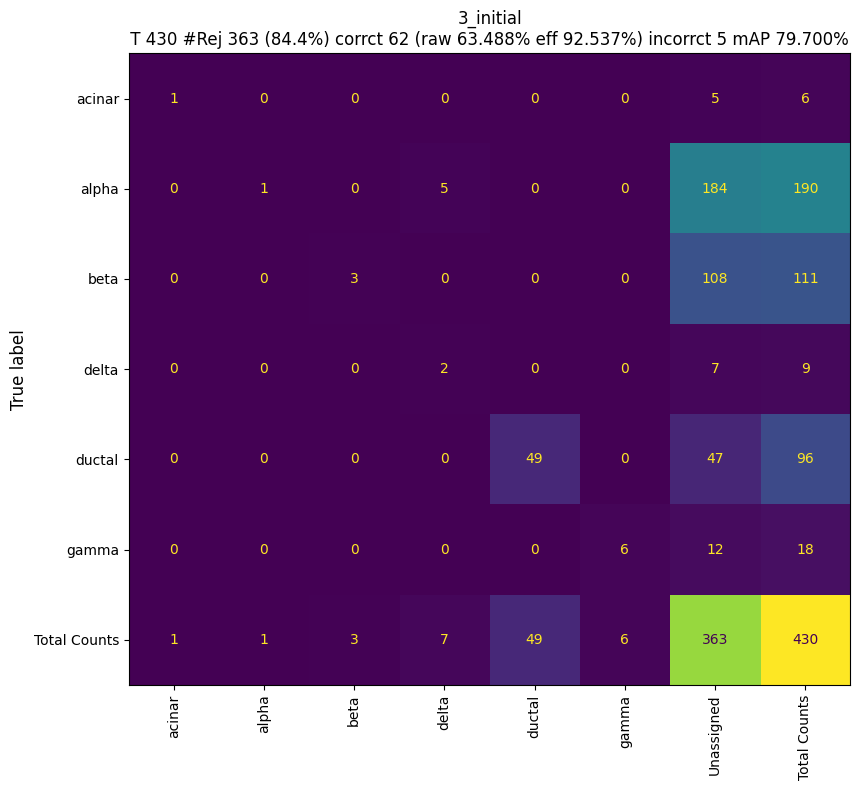

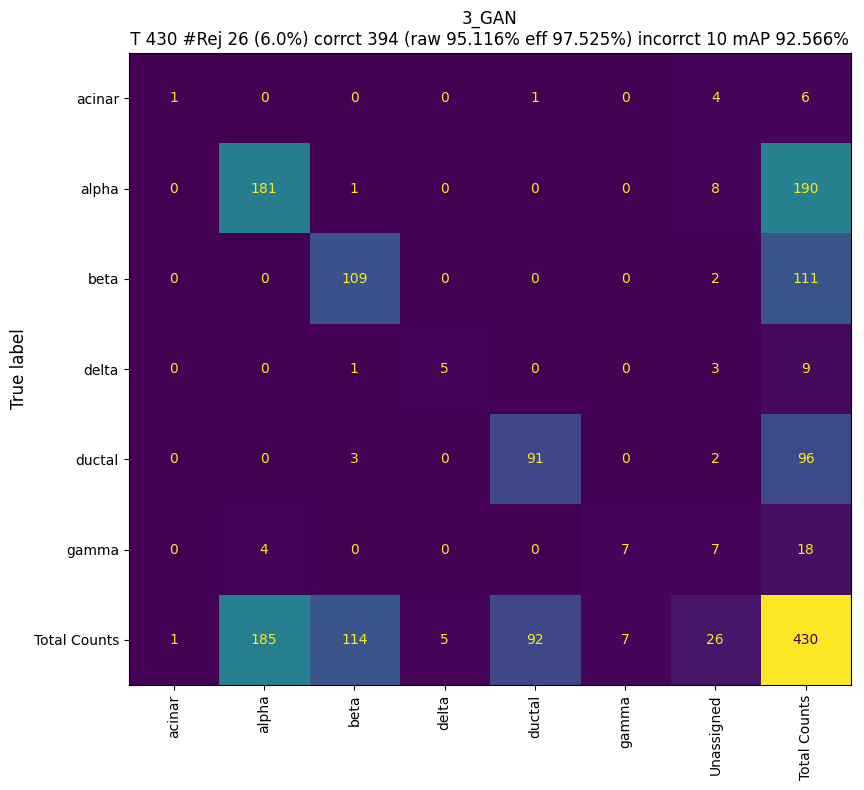

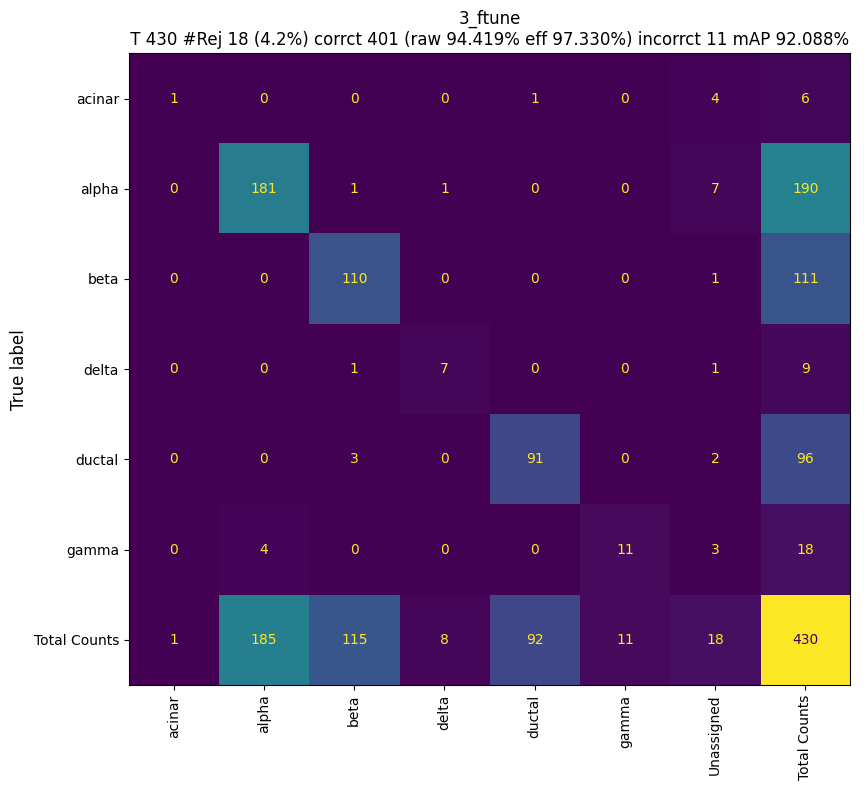

In [13]:
# Do JIND
jind2.train(target_data=test_data, model=model, val_stats=val_stats)

# 8 Conclusion

This notebook provided a comprehensive guide on configuring and running `JIND-Multi` for single-cell RNA sequencing analysis, using the Pancreas dataset with multiple labeled batches. It covered the key steps, including setting parameters, loading and processing data, and evaluating the model using confusion matrices. To tailor the analysis to your specific dataset and research objectives, adjust the parameters accordingly and review the results.

For further guidance on interpreting the results, please consult the `JIND-Multi` package documentation and the output files located in the `OUTPUT_PATH`.